In [7]:
import sys
sys.path.append("..")
from utils import append_derivatives_to_dataframe
from estimators.frequency import EIVSin
import numpy as np
from scipy.integrate import odeint, solve_ivp
from simulation.excitation_signals import sinusoidal_fun,  sweep_fun
import time
import matplotlib.pyplot as plt
from collections import Counter
import math
import pandas as pd

In [192]:
config = { "K": [[4300, 430],
          [430, 4300]],
    "C": [[40, 5],
          [5, 40]],
    "kp" : 7.5e3,
    "kd" : 18.61,
    "ki" : 180,
    "t" : 3,
    "f" : 4,
    "dt" : 0.0001}


In [229]:
class SimpleSystem:
    metadata = {'render.modes': ['human']}

    def __init__(self):
        """
        Define basic variables and constants

        - gravity
        - mass (of the axis)
        - inertia : moment of inertia
        - radius: tha radius of the axis at point A and B
        - bearing constant: the constant of the magnetic bearing (Fm = bearing_constant*i^2/d^2)
        - L : the distance between the center of mass of the axis and the magnetic bearing action point
        - dt : the time between iterations

        """

        self.reset_count = 1
        self.gravity = 9.80665
        self.gravity = 0
        self.mass = 1  # axis mass

        self.dt = 0
        self.q = np.array([[0],
                           [0]])
        self.q_dot = np.array([[0],
                           [0]])
        
        self.M = np.array([[1, 0],
                           [0, 1]])
        self.K = np.array([[0, 0],
                           [0, 0]])
        self.C = np.array([[0, 0],
                           [0, 0]])
        
        self.kp = 0
        self.kd = 0
        self.ki = 0
        
        self.q_ref = np.array([[0],
                               [0]])

    def solve(self, dt, t, force_fun):
        
        """
        
        
        Returns de solution
        
        """
        t_eval = np.arange(0, t, step=dt)
        
        v = self.M @ self.q_dot  + self.C @ self.q - self.kd * (self.q - self.q_ref)
        E = np.array([[0],
                      [0]])
        y = np.concatenate([v.flatten(), self.q.flatten(), E.flatten()], axis=0).flatten()
        sol = solve_ivp(fun=self.dynamics_fn, t_span=[0, t], y0=y, method='RK45',
                        args=(force_fun,), t_eval=t_eval)

        
        
        if sol['success']:
            
            f = np.array(list(map(force_fun, sol["t"])))
            y = sol["y"]
        
            return {"t" : sol["t"],
                    "x" : y[2, :],
                    "y" : y[3, :],
                    "fx" : f[:, 0],
                    "fy" : f[:, 1]}
            
        else:
            raise ValueError('Solver error')


    def dynamics_fn(self, t, y, f):
        """

        :param t: time
        :param y:  array of shape (12,) with position and velocity
        :param f:  force
        :param mass: mass
        :param gravity: gravity
        :param Icm:
        :return:
        """
        v, q, E = np.split(y, [2, 4])

        
        
        v = v.reshape((-1, 1))
        q = q.reshape((-1, 1))
        E = E.reshape((-1, 1))
        f = f(t).reshape((-1, 1))
        e = self.q_ref - q
        
        
        v_dot = - self.K @ q + f + self.kp * e + self.ki * E
        q_dot = np.linalg.inv(self.M) @ (v - self.C @ q + self.kd * e)
        
        dydt = np.concatenate([v_dot.flatten(), q_dot.flatten(), e.flatten()])
        
        return dydt

In [230]:
np.split([1,2,3,4], [2])

[array([1, 2]), array([3, 4])]

In [248]:


def get_data(config, axis="x"):
    
    dt = config["dt"]
    t  = config["t"]
    f = config["f"]

    env = SimpleSystem()
    env.K = np.array(config["K"])
    env.C = np.array(config["C"])
    env.kp = config["kp"]
    env.kd = config["kd"]
    env.ki = config["ki"]

    _force_fun = sinusoidal_fun(f, axis=axis)
    _force_fun = sweep_fun(T=config["t"], f1=4, f2=69, axis=axis)
    def force_fun(t):
     #   t = t % 1
        return 1*_force_fun(t)[:2]
    print(dt)
    res = env.solve(dt=dt, t=t, force_fun=force_fun)
    return res

df_x = pd.DataFrame(get_data(config, axis="x"))
df_y = pd.DataFrame(get_data(config, axis="y"))


0.0001
0.0001


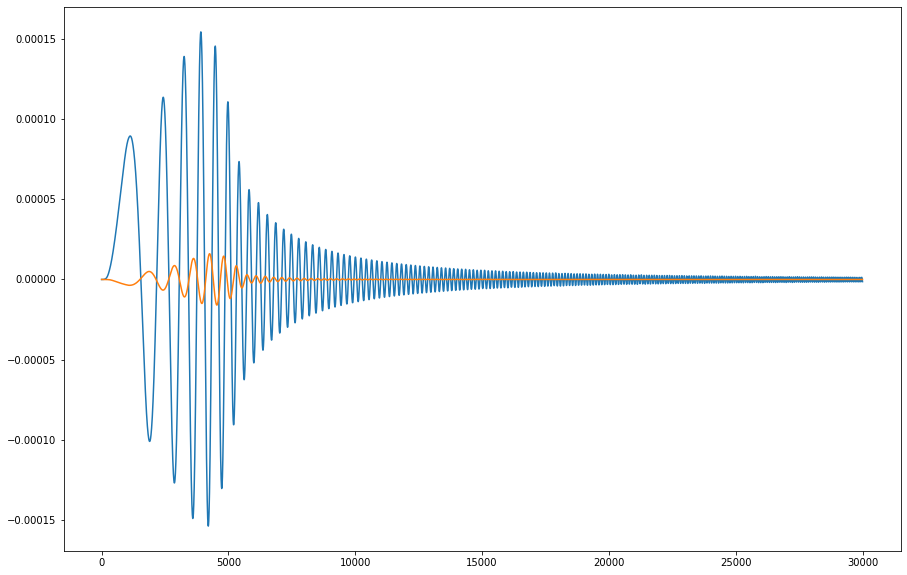

In [249]:
plt.figure(figsize=(15,10))
plt.plot(df_x.x)
plt.plot(df_x.y)

In [227]:


def get_data(config, axis="x"):
    
    dt = config["dt"]
    t  = config["t"]
    f = config["f"]

    env = SimpleSystem()
    env.K = np.array(config["K"])
    env.C = np.array(config["C"])
    #env.kp = config["kp"]
    #env.kd = config["kd"]
    #env.ki = config["ki"]

    _force_fun = sinusoidal_fun(f, axis=axis)
    #_force_fun = sweep_fun(T=1, f1=4, f2=69, axis=axis)
    def force_fun(t):
        t = t % 1
        return 10*_force_fun(t)[:2]
    print(dt)
    res = env.solve(dt=dt, t=t, force_fun=force_fun)
    return pd.DataFrame(res)

df_x = get_data(config, axis="x")
df_x["episode"] = 0
df_y = get_data(config, axis="y")
df_y["episode"] = 0

0.0001
0.0001


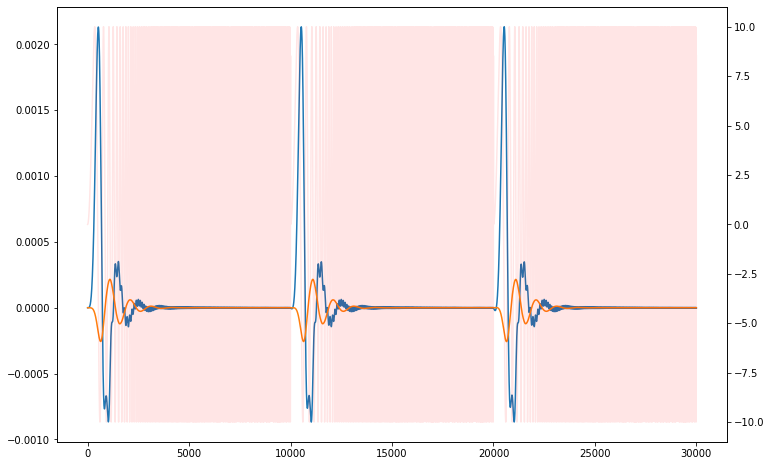

In [228]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.plot(df_x["fx"], color="red", alpha=0.1)
ax1.plot(df_x["x"])
ax1.plot(df_x["y"])
fig.show()
#plt.xlim((.4, 1))


In [60]:
df_x

,t,x,y,fx,fy,episode
0,0.0000,0.0,0.0,0.000000,0.0,0
1,0.0001,0.0,0.0,0.025133,0.0,0
2,0.0002,0.0,0.0,0.050265,0.0,0
3,0.0003,0.0,0.0,0.075398,0.0,0
4,0.0004,0.0,0.0,0.100529,0.0,0
...,...,...,...,...,...,...
19995,1.9995,0.0,0.0,-0.125660,-0.0,0
19996,1.9996,0.0,0.0,-0.100529,-0.0,0
19997,1.9997,0.0,0.0,-0.075398,-0.0,0
19998,1.9998,0.0,0.0,-0.050265,-0.0,0


In [61]:
df_x = append_derivatives_to_dataframe(df_x, "x", dt=config["dt"])
df_x = append_derivatives_to_dataframe(df_x, "y", dt=config["dt"])
df_y = append_derivatives_to_dataframe(df_y, "x", dt=config["dt"])
df_y = append_derivatives_to_dataframe(df_y, "y", dt=config["dt"])

In [62]:
df = pd.concat([df_x, df_y])
X = df[["x_dot", "y_dot", "x", "y"]].values
df["fx_"] = df["fx"] - 1*df["x_dot2"]
df["fy_"] = df["fy"] - 1*df["y_dot2"]
Y = df[["fx_", "fy_"]].values
params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
params

LinAlgError: Singular matrix